# 导入相关库

In [1]:
%matplotlib inline
import os
import pathlib
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
import pickle as pkl
from matplotlib import pyplot as plt
import random
from time import time
from tqdm.notebook import tqdm

# 数据获取和处理

In [2]:
# 数据目录下保存了很多csv文件，每个csv文件保存了一个5s的sequence，包含了多个车辆的轨迹信息
DATASET_PATH = "/ssd/datasets/argoverse/argoverse-forecasting-dataset/"
TRAIN = DATASET_PATH + "train/data"
VAL = DATASET_PATH + "val/data"
TEST = DATASET_PATH + "test_obs/data/"

def data_process(root_dir, mode):
    """
    处理root_dir目录下的CSV文件
    返回numpy array, shape: (total num of sequences, seq len, 4)
    """
    root_dir = pathlib.Path(root_dir)
    paths = [(root_dir / filename).absolute() for filename in os.listdir(root_dir)]
    seq_len = 50 if mode != "test" else 20
    features = np.empty((len(paths), seq_len, 4))
    for i in tqdm((range(len(paths)))):
        path = paths[i]
        sequence = pd.read_csv(path)
        agent_x = sequence[sequence["OBJECT_TYPE"] == "AGENT"]["X"]
        agent_y = sequence[sequence["OBJECT_TYPE"] == "AGENT"]["Y"]
        xy = np.column_stack((agent_x, agent_y))
        # 如果是train或者val，则xy shape: (50, 2) 记录了5秒（每秒10帧）的agent xy坐标
        # 否则xy shape: (20, 2)，是agent前2s的xy坐标
        vel = xy[1:] - xy[:-1]
        init_unknown_vel = np.array([np.nan, np.nan])
        vel = np.vstack((init_unknown_vel, vel))
        # vel shape: (seq len, 2)，差分得到速度，初始速度无法获取，设为NaN
        feature = np.column_stack((xy, vel))
        # feature shape: (seq len, 4), 各列分别是x, y, vel_x, vel_y
        features[i] = feature
    return features

def save_features_to_pkl(features, filepath):
    basedir = os.path.dirname(filepath)
    if not os.path.exists(basedir):
        os.makedirs(basedir)
    with open(filepath, 'wb') as f:
        pkl.dump(features, f)
        
def load_pkl_to_features(filepath):
    with open(filepath, 'rb') as f:
        features = pkl.load(f)
    return features

In [3]:
d = {"train": TRAIN,
     "val": VAL,
     "test": TEST} 
for mode, path in tqdm(d.items()):
    save_path = 'data/{}.pkl'.format(mode)
    if os.path.isfile(save_path):
        continue
    features = data_process(path, mode)
    save_features_to_pkl(features, save_path)

# 分析训练数据中Vx和Vy的均值和标准差

In [4]:
train_features = load_pkl_to_features("data/train.pkl")
print(train_features.shape)
train_velocity_mean = train_features[:, 1:, 2:4].mean((0, 1))
train_velocity_std = train_features[:, 1:, 2:4].std((0, 1))
print(train_velocity_mean, train_velocity_std)

(205942, 50, 4)
[ 0.01113458 -0.03050198] [0.67739089 0.81689616]


# 为Pytorch模型加载数据创建接口

In [5]:
class VelocityDataset(Dataset):
    
    def __init__(self, pkl_filepath, mode, obs_len = 20, transform = None):
        self.mode = mode
        self.features = load_pkl_to_features(pkl_filepath)
        self.obs_len = obs_len
        self.transform = transform
        
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        # 返回source以及target velocity
        src = self.features[idx, 1:self.obs_len, 2:4]
        trg = self.features[idx, self.obs_len:, 2:4]
        if self.transform:
            src = self.transform(src)
            trg = self.transform(trg)
        return src, trg
    
class WrappedDataLoader:
    def __init__(self, dataloader, func):
        self.dataloader = dataloader
        self.func = func
        
    def __len__(self):
        return len(self.dataloader)
    
    def __iter__(self):
        iter_dataloader = iter(self.dataloader)
        for batch in iter_dataloader:
            yield self.func(*batch)

def batch_second(x, y):
    """
    输入: x = [batch size, 19, 4], y = [batch size, 30, 4]
    我们将batch size 放到第二个维度，从而使
    x = [19, batch size, 4]
    y = [30, batch size, 4]
    """
    return x.transpose(0, 1), y.transpose(0, 1)

# 数据预处理（转换为Tensor，归一化，batch换到第二个维度方便使用nn.Transformer）

In [6]:
class Normalize:
    """
    对输入数据进行归一化处理
    """
    def __init__(self, mean, std):
        self.mean = torch.Tensor(mean) 
        self.std = torch.Tensor(std)

    def __call__(self, x):
        x = torch.Tensor(x)
        return x.sub_(self.mean).div_(self.std)
        
transform = Normalize(mean=train_velocity_mean, std=train_velocity_std)

train_dataset = VelocityDataset("data/train.pkl", "train", transform=transform)
val_dataset = VelocityDataset("data/val.pkl", "val", transform=transform)
test_dataset = VelocityDataset("data/test.pkl", "test", transform=transform)

BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)
train_loader = WrappedDataLoader(train_loader, batch_second)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=6)
val_loader = WrappedDataLoader(val_loader, batch_second)

In [7]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([19, 128, 2]) torch.Size([30, 128, 2])


# 定义Transformer模型

In [8]:
class TrajectoryTransformer(nn.Module):
    def __init__(self,
                 device,
                 source_seq_len: int = 19,
                 target_seq_len: int = 30,
                 input_dim: int = 2,
                 output_dim: int = 2,
                 d_model: int = 512,
                 nhead: int = 8,
                 num_encoder_layers: int = 6,
                 num_decoder_layers: int = 6,
                 dim_feedforward: int = 2048,
                 dropout: float = 0.1,
                 activation: str = 'relu'):
        super().__init__()
        self.source_seq_len = source_seq_len
        self.target_seq_len = target_seq_len
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.total_seq_len = self.source_seq_len + self.target_seq_len
        self.device = device
        self.scale = torch.sqrt(torch.FloatTensor([d_model])).to(device)
        
        self.encoder_embedding = nn.Linear(input_dim, d_model)
        self.decoder_embedding = nn.Linear(output_dim, d_model)
        self.pos_embedding = nn.Embedding(self.total_seq_len, d_model)
        self.transformer = nn.Transformer(d_model,
                                          nhead,
                                          num_encoder_layers,
                                          num_decoder_layers,
                                          dim_feedforward,
                                          dropout,
                                          activation)
        self.linear = nn.Linear(d_model, output_dim)
    
    def forward(self, src, trg):
        """
        src shape: (19, batch size, 2)
        trg shape: (30, batch size, 2)
        """
        decoder_input_len = trg.shape[0]
        decoder_mask = self.transformer.generate_square_subsequent_mask(decoder_input_len).to(self.device)
        # decoder_mask shape: (30, 30), 用来进行30次计算（可并行），每次计算用mask的一行
        
        encoder_input = self.encoder_embedding(src) * self.scale
        # encoder_input shape: (19, batch size, 512)
        
        encoder_pos_embedding =  self.pos_embedding(
                                    torch.arange(0, self.source_seq_len, device=self.device)
                                 ).unsqueeze(1)
        # encoder_pos_embedding shape: (19, 1, 512), add second dim to allow broadcasting addition
        
        encoder_input += encoder_pos_embedding 
        
        
        # concat start of sequence (zeros) with trg without last item to form decoder input
        start_of_sequence = torch.zeros(1, trg.shape[1], trg.shape[2], device=self.device)
        decoder_input = torch.cat((start_of_sequence, trg[:-1, :, :]), 0)
        
        decoder_input = self.decoder_embedding(decoder_input) * self.scale + \
                        self.pos_embedding(
                            torch.arange(self.source_seq_len,
                                         self.total_seq_len,
                                         device=self.device)
                        ).unsqueeze(1)
        # decoder_input shape: (30, batch size, 512)
        
        output = self.transformer(encoder_input, decoder_input, tgt_mask = decoder_mask)
        # output shape: (30, batch size, 512)
        
        return self.linear(output)
        # return tensor shape: (30, batch size, 2)

# 创建模型并初始化模型参数

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_weights(model):
    if hasattr(model, 'weight') and model.weight.dim() > 1:
        nn.init.xavier_uniform_(model.weight.data)
        
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dev)
model = TrajectoryTransformer(device = dev).to(dev)
print(f'The model has {count_parameters(model):,} trainable parameters')
model.apply(initialize_weights)

cuda:0
The model has 44,169,730 trainable parameters


TrajectoryTransformer(
  (encoder_embedding): Linear(in_features=2, out_features=512, bias=True)
  (decoder_embedding): Linear(in_features=2, out_features=512, bias=True)
  (pos_embedding): Embedding(49, 512)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): Multih

# 创建自定义损失函数EuclideanDistanceLoss

In [10]:
def EuclideanDistanceLoss(output, target):
    """
    output shape: (30, batch size, 2), 为预测的车辆速度
    target shape is the same, 为车辆速度真值
    这里我们计算所有预测速度和真实速度的欧几里得距离，然后将计算结果取平均得到我们的损失
    """
    output = output.contiguous().view(-1, 2)
    target = target.contiguous().view(-1, 2)
    return F.pairwise_distance(output, target).mean()

for x, y in train_loader:
    print(EuclideanDistanceLoss(x, -x))
    break

tensor(2.3903)


# 初始化optimizer以及criterion

In [11]:
LEARNING_RATE = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = EuclideanDistanceLoss

# 定义训练和测试流程

In [12]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, (src, trg) in tqdm(enumerate(iterator), total=len(iterator)):
        src = src.to(dev)
        trg = trg.to(dev)
        
        optimizer.zero_grad()
        output = model(src, trg)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (src, trg) in tqdm(enumerate(iterator), total=len(iterator)):
            src = src.to(dev)
            trg = trg.to(dev)
            
            output = model(src, trg)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

# 定义推理流程并做一些可视化
推理是比较有难度的部分，看起来不是特别直观。

注意尽管我们之前都是给模型直接传入理想的输出，但是在推理的时候，这个信息一般是没有的，所以我们需要迭代地计算出每一步的输出，并将这个输出加入到下一次的输入, 这个是大致的思路。

另外，虽然我们在训练的时候传入的decode input的序列长度都是30，但是实际上Transformer decoder可以接受变长的序列长度输入，所以我们开始的时候可以直接给decoder传入一个序列长度的sequence，然后每一轮迭代将输出结果添加到这个sequence中，最后我们就获得了包含start of sequence以及30个预测点的输出。

In [13]:
def predict(model, agent_observed_vels):
    """
    agent_observed_vels: [19, 2]
    return predicted vels: [30, 2]
    """
    model.eval()
    with torch.no_grad():
        encoder_input = torch.Tensor(agent_observed_vels).unsqueeze(1).to(model.device)
        encoder_input = model.encoder_embedding(encoder_input) * model.scale + \
                        model.pos_embedding(
                            torch.arange(0, model.source_seq_len, device=model.device)
                        ).unsqueeze(1)
        # encoder_pos_embedding shape: (19, 1, 512)
        
        # 保存encoder的输出结果, 之后传给decoder
        memory = model.transformer.encoder(encoder_input)
        
        prediction = torch.zeros(model.target_seq_len + 1, 1, model.output_dim, device=model.device)
        # prediction shape: (31, 1, 2), 用来保存start of sequence以及之后计算得到的输出序列 
        for i in range(model.target_seq_len):
            cur_len = i + 1
            decoder_mask = model.transformer.generate_square_subsequent_mask(cur_len).to(model.device)
            decoder_input = prediction[:cur_len]
            decoder_input = model.decoder_embedding(decoder_input) * model.scale + \
                            model.pos_embedding(
                                torch.arange(model.source_seq_len,
                                             model.source_seq_len + cur_len,
                                             device=model.device)
                            ).unsqueeze(1)
            out = model.transformer.decoder(decoder_input, memory, decoder_mask)
            output = model.linear(out)
            prediction[cur_len] = output[i]
        return prediction[1:].squeeze(1)

In [14]:
def vels_to_coords(vels, start = np.zeros((1, 2))):
    xy = np.zeros(vels.shape)
    xy[0] = start
    for i in range(1, vels.shape[0]):
        xy[i] = vels[i]
        xy[i] += xy[i - 1]
    return xy
        
def plot_trajectory(prediction, groud_truth = None, obs_len = 20, start = np.zeros((1, 2))):
    pred_xy = vels_to_coords(prediction, start)
    figure = plt.figure(figsize=(10,10))
    plt.scatter(pred_xy[:obs_len, 0], pred_xy[:obs_len, 1], label="observed trajectory")
    plt.scatter(pred_xy[obs_len:, 0], pred_xy[obs_len:, 1], label="prediction")
    if groud_truth is not None:
        gt_xy = vels_to_coords(groud_truth, start)
        plt.scatter(gt_xy[obs_len:, 0], gt_xy[obs_len:, 1], label="ground truth")
    plt.legend()
    return figure

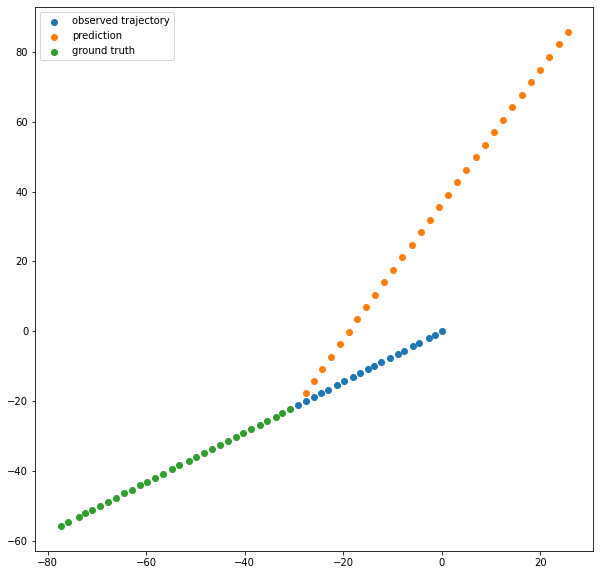

In [15]:
def plot_random_sample(model, dataset):
    idx = random.randrange(len(dataset))
    x, y = dataset[idx]
    y_pred = predict(model, x)
    y_pred = y_pred.cpu().numpy()
    x, y = x.cpu().numpy(), y.cpu().numpy()
    zero = np.zeros((1, 2))
    ground_truth = np.concatenate((zero, x, y), axis=0)
    prediction = np.concatenate((zero, x, y_pred), axis=0)
    return plot_trajectory(prediction, ground_truth)
fig = plot_random_sample(model, train_dataset)

# 开始训练 

In [16]:
best_val_loss = float('inf')

In [17]:
start_epoch = 0

In [ ]:
N_EPOCHES = 100
writer = SummaryWriter("runs/transformer_experiment_3")
CLIP = 1

# load previous best model params if exists
model_dir = "saved_models/ReformattedTransformer"
saved_model_path = model_dir + "/best_transformer.pt"
if os.path.isfile(saved_model_path):
    model.load_state_dict(torch.load(saved_model_path))
    print("successfully load previous best model parameters")
    
for epoch in tqdm(range(N_EPOCHES)):
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    val_loss = evaluate(model, val_loader, criterion)
    
    print(F'Epoch: {epoch+1:02}')
    print(F'\tTrain Loss: {train_loss:.3f}')
    print(F'\t Val. Loss: {val_loss:.3f}')
    
    step = start_epoch + epoch
    writer.add_scalar('Loss/train', train_loss, step)
    writer.add_scalar('Loss/val', val_loss, step)
    writer.add_figure('Image/train', plot_random_sample(model, train_dataset), step)
    writer.add_figure('Image/val', plot_random_sample(model, val_dataset), step)
    writer.flush()

    if val_loss < best_val_loss:
        os.makedirs(model_dir, exist_ok=True)
        torch.save(model.state_dict(), saved_model_path)
        
start_epoch += N_EPOCHES
writer.close()

successfully load previous best model parameters
